## **1. Importación de librerias y datos**

In [23]:
import pandas as pd

data = pd.read_csv("listings_cleaned.csv")
data['review_scores'] = data['review_scores'].astype(float)
data.head()

,id,last_scraped,name,host_id,host_name,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,...,calculated_host_listings_count_shared_rooms,reviews_per_month,review_scores,days_since_last_review,price_per_person,price_category,property_type_simple,occupancy_rate,is_entire_place,capacity_category
0,31840,2025-06-19,Residenza Martin Classic room,380378,Andrea,2011-02-07,within an hour,0.99,1.0,Sin registro,...,0,0.85,4.791429,177.0,65.000000,Medio,Apartment,0.410959,False,Pareja
1,32180,2025-06-19,Charming Gem - Oltrarno City centre,13925330,Cesare,2014-04-05,within a day,0.83,0.75,False,...,0,0.22,4.792857,198.0,28.000000,Medio,Apartment,0.230137,True,Pequeño
2,39822,2025-06-19,Apartment Santa Monaca Oltrarno old town,154769,Matilde,2010-06-29,within an hour,1.0,1.0,True,...,0,0.19,4.584286,198.0,24.250000,Económico,Apartment,0.109589,True,Pequeño
3,44781,2025-06-19,Stylish Terrace on Boboli Gardens,33210,Rocco,2009-08-22,within an hour,1.0,0.98,True,...,0,2.47,4.881429,175.0,43.250000,Medio,Apartment,0.575342,True,Pequeño
4,46520,2025-06-19,Residenza Martin: Superior room,380378,Andrea,2011-02-07,within an hour,0.99,1.0,Sin registro,...,0,0.76,4.857143,176.0,41.666667,Medio,Apartment,0.509589,False,Pequeño


## **2. Construcción del target (para clasificación)**
Este target es sólido para un producto analítico porque combina desempeño real (ocupación) y percepción del huésped (calificación).

In [24]:
df = data.copy()

# Criterios recomendados
df["recommended"] = (
    (df["occupancy_rate"] >= 0.65) &
    (df["review_scores"] >= 4.6)
).astype(int)

df["recommended"].value_counts()

recommended
0    8972
1    2011
Name: count, dtype: int64

## **3. Selección de variables y preparación**

In [25]:
num_features = [
    "accommodates", "bedrooms", "beds", "latitude", "longitude",
    "occupancy_rate", "price_per_person", "minimum_nights",
    "maximum_nights", "number_of_reviews", "host_total_listings_count",
    "review_scores", "reviews_per_month"
]

df["bedrooms"] = pd.to_numeric(df["bedrooms"], errors="coerce").fillna(0)
df["beds"] = pd.to_numeric(df["beds"], errors="coerce").fillna(0)

# Variables categóricas recomendadas
cat_features = ["neighbourhood_cleansed", "property_type_simple", "host_is_superhost"]
df = pd.get_dummies(df, columns=cat_features, drop_first=True)

# DF final para modelos
feature_cols = num_features + [c for c in df.columns if any(feat in c for feat in cat_features)]

X = df[feature_cols].values
y_reg = df["price"].values
y_clf = df["recommended"].values

## **4. División de los datos en train/test**

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# División
X_train, X_test, y_train_reg, y_test_reg = train_test_split(X, y_reg, test_size=0.2, random_state=42)
_, _, y_train_clf, y_test_clf = train_test_split(X, y_clf, test_size=0.2, random_state=42)

# Escalamiento
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## **5. Creación de los modelos**
### Modelo de regresión

In [27]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Modelo de regresión
reg_model = keras.Sequential([
    layers.Dense(128, activation="relu", input_shape=(X_train.shape[1],)),
    layers.Dense(64, activation="relu"),
    layers.Dense(1)
])

reg_model.compile(
    optimizer="adam",
    loss="mse",
    metrics=["mae"]
)

history_reg = reg_model.fit(
    X_train, y_train_reg,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    verbose=1
)

Epoch 1/50


c:\Users\peter\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


220/220 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 584098.3125 - mae: 209.5126 - val_loss: 560296.0000 - val_mae: 154.2592
Epoch 2/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 435166.6250 - mae: 183.2936 - val_loss: 407395.5938 - val_mae: 211.5087
Epoch 3/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 323186.9375 - mae: 192.7386 - val_loss: 296390.9375 - val_mae: 173.5557
Epoch 4/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 215823.4844 - mae: 153.9128 - val_loss: 240992.2500 - val_mae: 159.2410
Epoch 5/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 147568.7500 - mae: 127.7746 - val_loss: 254183.7344 - val_mae: 126.8990
Epoch 6/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 121184.4609 - mae: 106.8673 - val_loss: 279795.2812 - val_mae: 117.4711
Epoch 7/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 111261.7500 - mae: 96.5541 - val_loss: 301890.9688 - val_mae: 110.5232
Epoch 8/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 107413.7656 - mae: 90.8537 -

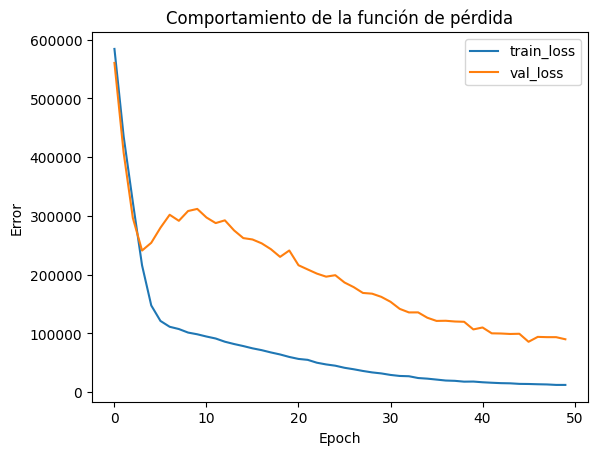

In [28]:
import matplotlib.pyplot as plt

plt.plot(history_reg.history['loss'], label='train_loss')
plt.plot(history_reg.history['val_loss'], label='val_loss')

plt.title("Comportamiento de la función de pérdida")
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend()

### Modelo de clasificación

In [29]:
clf_model = keras.Sequential([
    layers.Dense(128, activation="relu", input_shape=(X_train.shape[1],)),
    layers.Dense(64, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

clf_model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

history_clf = clf_model.fit(
    X_train, y_train_clf,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    verbose=1
)

Epoch 1/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9308 - loss: 0.1790 - val_accuracy: 0.9704 - val_loss: 0.0852
Epoch 2/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9747 - loss: 0.0741 - val_accuracy: 0.9807 - val_loss: 0.0611
Epoch 3/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9806 - loss: 0.0535 - val_accuracy: 0.9795 - val_loss: 0.0607
Epoch 4/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9832 - loss: 0.0447 - val_accuracy: 0.9824 - val_loss: 0.0545
Epoch 5/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9875 - loss: 0.0380 - val_accuracy: 0.9852 - val_loss: 0.0447
Epoch 6/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9892 - loss: 0.0328 - val_accuracy: 0.9784 - val_loss: 0.0666
Epoch 7/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9890 - loss: 0.0294 - val_accuracy: 0.9841 - val_loss: 0.0481
Epoch 8/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9892 - loss: 0.0288 - val_accuracy: 0.

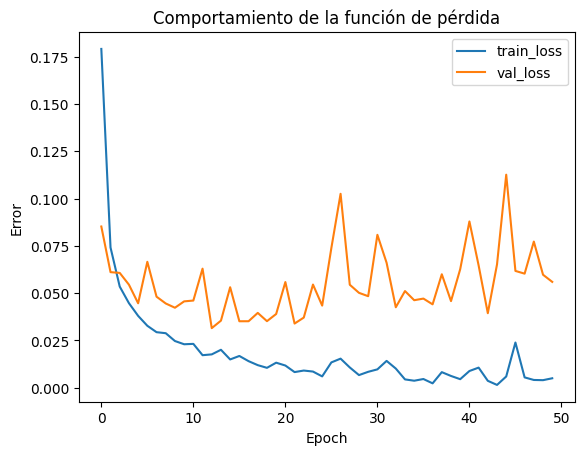

In [30]:
import matplotlib.pyplot as plt

plt.plot(history_clf.history['loss'], label='train_loss')
plt.plot(history_clf.history['val_loss'], label='val_loss')

plt.title("Comportamiento de la función de pérdida")
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend()

## **6. Evaluación de los modelos**

In [31]:
from sklearn.metrics import mean_absolute_error, r2_score, classification_report, confusion_matrix

# Regresión
y_pred_reg = reg_model.predict(X_test).flatten()
print("MAE:", mean_absolute_error(y_test_reg, y_pred_reg))
print("R2:", r2_score(y_test_reg, y_pred_reg))

# Clasificación
y_pred_clf = (clf_model.predict(X_test) > 0.65).astype(int)
print(classification_report(y_test_clf, y_pred_clf))
print(confusion_matrix(y_test_clf, y_pred_clf))

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
MAE: 41.72833109683322
R2: 0.9612649261188758
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1811
           1       0.95      0.98      0.96       386

    accuracy                           0.99      2197
   macro avg       0.97      0.98      0.98      2197
weighted avg       0.99      0.99      0.99      2197

[[1792   19]
 [   9  377]]


La matriz de confusión tiene la forma:

TN  FP  
FN  TP

Donde:

TN = verdaderos negativos  
TP = verdaderos positivos  
FP = falsos positivos (error tipo I)  
FN = falsos negativos (error tipo II)

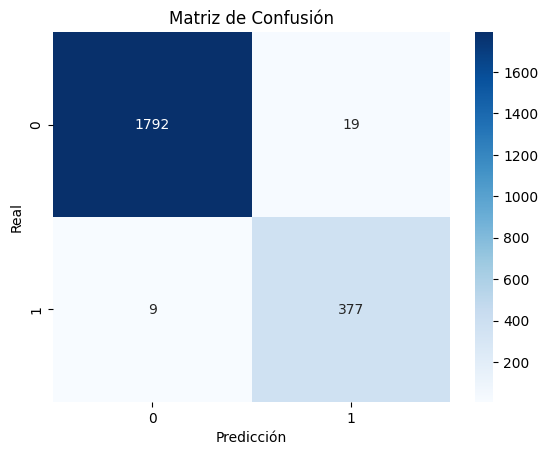

In [32]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Matriz de confusión
matriz_confusion = confusion_matrix(y_test_clf, y_pred_clf)

# Visualización de la matriz de confusión
sns.heatmap(matriz_confusion, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

## **7. Exportación para MLflow**

In [33]:
reg_model.save("regression_model.h5")
clf_model.save("classification_model.h5")